# Tiny Lipi Implementation

This notebook presents the implementation of a Competitive Coevolutionary Generative Adversarial Network (GAN) Training using PyTorch to address the problem of generating synthetic data that resembles real data. The real data is a ring mixture dataset.



## Main imports

In [17]:
import models
import train
import evaluation
import dataset
import importlib

# Reload to capture any external file changes
importlib.reload(dataset)
importlib.reload(models)
importlib.reload(train)
importlib.reload(evaluation)

from models import GenerativeModel, DiscriminativeModel
from dataset import RingMixtureDataset
from train import train_one_epoch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from visualization import Visualizer

## Training paramenters configurarion

- z_dim: dimension of the Generator input noise vector z (here 2D, convenient for visualization in toy 2D GANs).
- training_epochs: number of full passes through the dataset.
- population_size: number of individuals in each adversarial population.
- ensemble_evolution_steps: number of Evolutionary Strategies steps applied to evolve the generative ensemble.

**RingMixtureDataset** is a custom dataset that produces a toy 2D distribution (a mixture arranged on a ring).
- batch_size: number of real samples processed per training step.
- dataset_size: how many samples to generate in the synthetic dataset.
- samples_to_visualize: how many points we will plot when visualizing the learned distribution.

**Neural Networs**
- hidden_layer_size: width of the hidden layers for both networks (small here because this is a simple toy problem).
- gen_population = GenerativeModel(...) creates the generative model defined as a population of generators.
- disc_population = DiscriminativeModel(...) creates the discriminative model defined as a population of discriminators.

**Loss**
- nn.BCEWithLogitsLoss() implements binary cross-entropy where the input is a logit (raw score). It is commonly used in GANs where the Discriminator predicts “real” vs “fake”.

In [ ]:
z_dim = 2
training_epochs = 50
population_size = 5
ensemble_evolution_steps = 50

batch_size = 32
dataset_size = 2000
num_visualization_samples = 2000
dataset = RingMixtureDataset(n_samples=dataset_size, collapse_to=[], k=8)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)

hidden_layer_size = 16
loss_criterion = nn.BCEWithLogitsLoss()
gen_population = GenerativeModel(population_size, z_dim=z_dim, h=hidden_layer_size)
disc_population = DiscriminativeModel(population_size, h=hidden_layer_size, dataloader=dataloader)



Discriminative Model initialized.


## Coevolutionary loop loop + live visualization

This cell sets up a **Visualizer** to display training progress inside the notebook, then runs the **CoEvolutionary training loop**.  
1. Initialize Populations: Create populations of Generators and Discriminators. Done before.
2. Initial Evaluation: Set up metrics evaluation (SWD, Modes).
3. **CoEvolutionary Loop** (Generations):
    - a. Selection: Choose parents based on fitness.
    - b. Variation (Training): Train offspring using standard GAN algorithms.
    - c. Evaluation: Compute fitness for offspring via interactions.
    - d. Replacement: Replace worst performing individuals in the population.
4. Visualization: Plot loss curves, generated samples, and metrics in real-time.
5. Update the plots interactively.

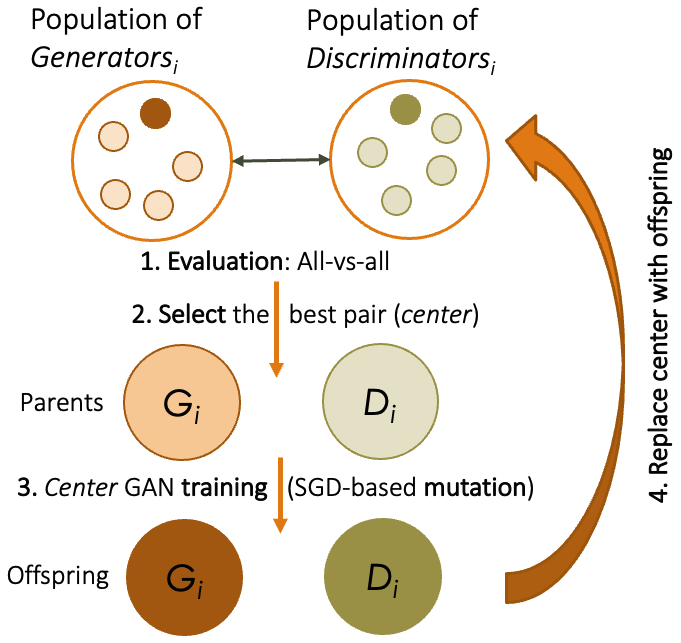


Evaluation considers quality/diversity metrics:
- SWD: distribution match (quality)
- JS divergence to uniform: mode balance (diversity)
- Coverage: how many modes the Generator learned to represent


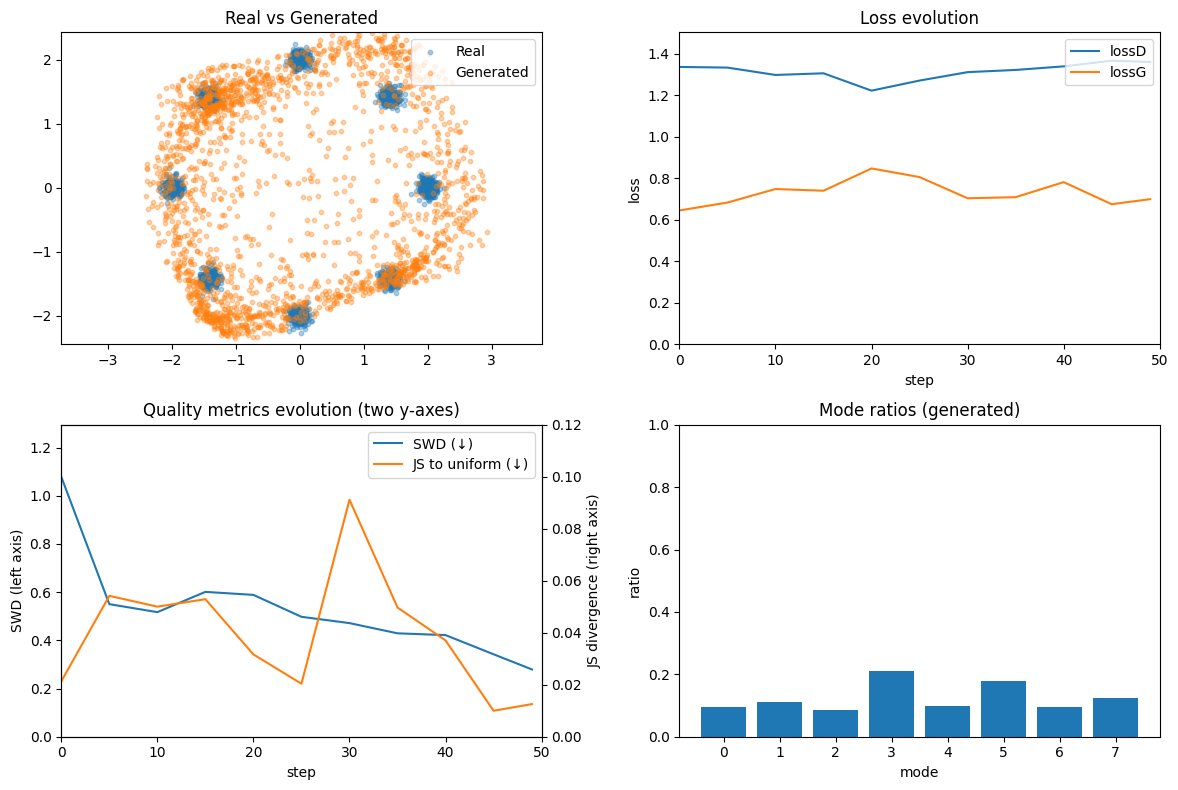

EPOCH[49] stats: SWD 0.2791 | JS divergence 0.0126 | Coverage: 8


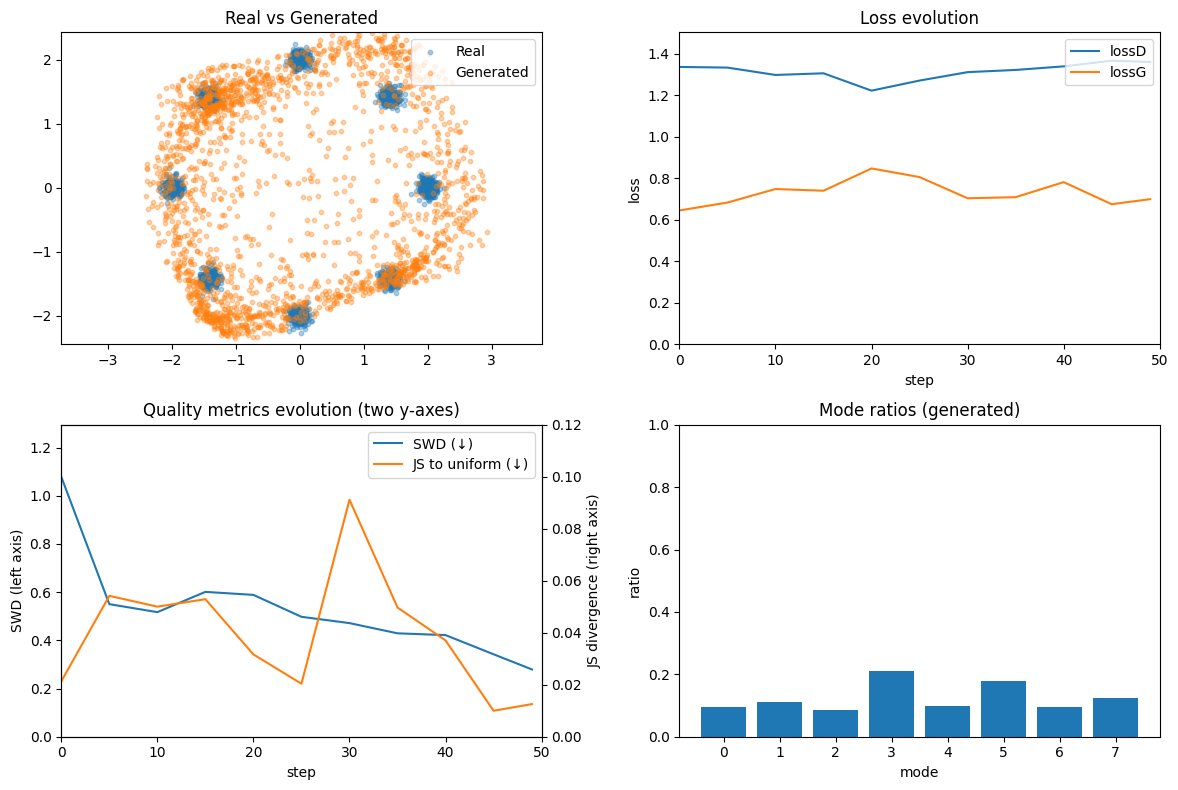

In [19]:
# Plot setup: 2x2 dashboard
visualizer = Visualizer(dataset, samples_to_visualize=num_visualization_samples, notebook_mode=True, max_steps=training_epochs)
print("Setup complete. Starting training...")

# 2. Initial Evaluation
gen_population.evaluate_population(disc_population, dataloader, num_batches=5)
disc_population.evaluate_population(gen_population, dataloader, num_batches=5)

for epoch in range(training_epochs):
    # 3.a. Selection
    offspring_generator = gen_population.selection(2)
    offspring_discriminator = disc_population.selection(2)
    
    # 3.b.. Variation operator
    disc_loss, gen_loss = train_one_epoch(
        offspring_generator, offspring_discriminator, 
        offspring_generator.optimizer, offspring_discriminator.optimizer, 
        offspring_discriminator.dataloader, 
        loss_criterion, d_steps=1, z_dim=2, device="cpu"
    )
    offspring_generator.generation += 1
    offspring_discriminator.generation += 1
    gen_population.insert_individual(offspring_generator)
    disc_population.insert_individual(offspring_discriminator)

    # 3.c. Evaluation
    gen_population.evaluate_population(disc_population, dataloader, num_batches=5)
    disc_population.evaluate_population(gen_population, dataloader, num_batches=5)

    # 3.d. Replacement
    gen_population.remove_n_worst_individuals(1)
    disc_population.remove_n_worst_individuals(1)

    #gen_population.info()
    #disc_population.info()

    


    if epoch % 5 == 0 or epoch == training_epochs-1:
        generated_samples, swd_metric, stats = gen_population.evaluate_metrics(dataset)
        visualizer.update(epoch, disc_loss, gen_loss, generated_samples, swd_metric, stats)
        print(f"EPOCH[{epoch}] stats: SWD {swd_metric:.4f} | JS divergence {stats['js_to_uniform']:.4f} | Coverage: {stats['coverage']}")

    




## Generarive Model Ensemble Evolution + visualization

Basic **ensemble optimization** by using Evolutionar Strategies. In this case we use two different fitness functions:
- **SWD**: distribution match (quality) 'swd'
- **JS divergence to uniform**: mode balance (diversity) 'other'

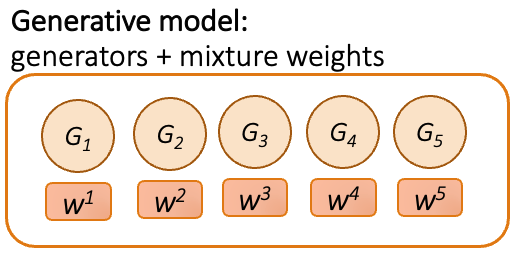

In [20]:
metric = 'swd'
best_fitness = swd_metric if metric == "swd" else stats["js_to_uniform"]
metric_name = 'SWF' if metric == "swd" else 'JS divergence'
best_weights = []
es_generations = 100
print(f"Ensemble evolution [BEFORE]: {metric_name} {best_fitness:.4f}")

for generation in range(ensemble_evolution_steps):
    gen_population.evolve_ensemble_weights(dataset, metric='swd', num_samples=num_visualization_samples, n_perturbations=20, sigma=0.05, learning_rate=0.1)
    generated_samples, swd_metric, stats = gen_population.evaluate_metrics(dataset)
    
    fitness = swd_metric if metric == "swd" else stats["js_to_uniform"]

    if fitness < best_fitness:
        best_fitness = fitness
        best_weights =  gen_population.ensemble_weights
    
    if generation%5 == 0:
        print(f"Ensemble evolution [{generation}]: {metric_name} {best_fitness:.4f}")



print(f"Ensemble evolution [AFTER]: {metric_name} {best_fitness:.4f}")


Ensemble evolution [BEFORE]: SWF 0.2791
Ensemble evolution [0]: SWF 0.2791
Ensemble evolution [5]: SWF 0.2674
Ensemble evolution [10]: SWF 0.2674
Ensemble evolution [15]: SWF 0.2640
Ensemble evolution [20]: SWF 0.2506
Ensemble evolution [25]: SWF 0.2506
Ensemble evolution [30]: SWF 0.2506
Ensemble evolution [35]: SWF 0.2506
Ensemble evolution [40]: SWF 0.2486
Ensemble evolution [45]: SWF 0.2460
Ensemble evolution [50]: SWF 0.2460
Ensemble evolution [55]: SWF 0.2460
Ensemble evolution [60]: SWF 0.2460
Ensemble evolution [65]: SWF 0.2460
Ensemble evolution [70]: SWF 0.2460
Ensemble evolution [75]: SWF 0.2460
Ensemble evolution [80]: SWF 0.2460
Ensemble evolution [85]: SWF 0.2460
Ensemble evolution [90]: SWF 0.2460
Ensemble evolution [95]: SWF 0.2460
Ensemble evolution [AFTER]: SWF 0.2425


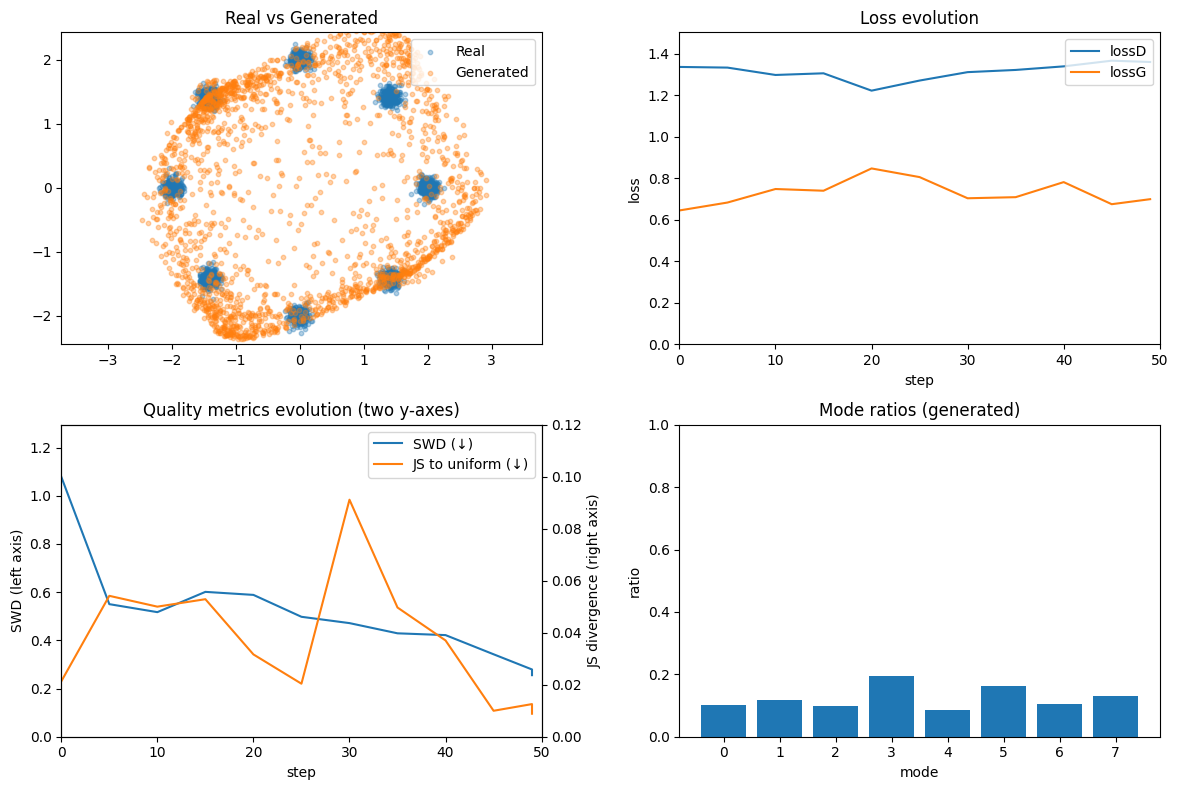

In [21]:
generated_samples, swd_metric, stats = gen_population.evaluate_metrics(dataset, weights=best_weights)
visualizer.update(epoch, disc_loss, gen_loss, generated_samples, swd_metric, stats)
